In [38]:
from sympy import *
import numpy as np
from IPython.display import Math
import matplotlib.pyplot as plt

# Modified Denavit Parameters of Kuka Robot

In [18]:
alpha = [pi, pi/2, 0, -pi/2, pi/2, -pi/2]
# a = [0, symbols('a2'), symbols('a3'), symbols('a4'), 0 ,0]
q = [symbols('q1'), symbols('q2'), symbols('q3'), symbols('q4'), symbols('q5'), symbols('q6')]
# r = [-symbols('r1'), 0, 0, -symbols('r4'), 0, 0]

val_a = [0, 0.26, 0.68, 0.035, 0, 0]
val_r = [-0.675, 0, 0, -0.67, 0, 0]

a = val_a
r = val_r

mdh_table = {'joint1' : [alpha[0], a[0], q[0], r[0]],
            'joint2' : [alpha[1], a[1], q[1], r[1]],
            'joint3' : [alpha[2], a[2], pi/2 + q[2], r[2]],
            'joint4' : [alpha[3], a[3], q[3], r[3]],
            'joint5' : [alpha[4], a[4], q[4], r[4]],
            'joint6' : [alpha[5], a[5], q[5], r[5]]}

# Homogeneous transform from Fi-1 to Fi

In [19]:
def poseFi(mdh_row):
    # unpack input
    alpha = mdh_row[0]
    a = mdh_row[1]
    q = mdh_row[2]
    r = mdh_row[3]
    
    trans_about_x = Matrix([[1, 0, 0, a],
                         [0, cos(alpha), -sin(alpha), 0],
                         [0, sin(alpha), cos(alpha), 0],
                         [0, 0, 0, 1]])
    
    trans_about_z = Matrix([[cos(q), -sin(q), 0, 0],
                         [sin(q), cos(q), 0, 0],
                         [0, 0, 1, r],
                         [0, 0, 0, 1]])
    return trans_about_x * trans_about_z
    

# Forward Geometric 

In [20]:
M0_1 = poseFi(mdh_table['joint1'])
M1_2 = poseFi(mdh_table['joint2'])
M2_3 = poseFi(mdh_table['joint3'])
M3_4 = poseFi(mdh_table['joint4'])
M4_5 = poseFi(mdh_table['joint5'])
M5_6 = poseFi(mdh_table['joint6'])

# t6e = symbols('t6e')
t6e = 0.158
M6_E = poseFi([pi, 0, 0, t6e])

# pose of E-E relative to frame 0
M0_E = M0_1 * M1_2 * M2_3 * M3_4 * M4_5 * M5_6 * M6_E

# coordinate of E-E check
val_q = zeros(6)
val_M0_E = M0_E.subs(zip(q, val_q))

print('Pose of E-E when all joints at neutral position:')
pprint(val_M0_E)


Pose of E-E when all joints at neutral position:
⎡0   0  1  1.768⎤
⎢               ⎥
⎢0   1  0    0  ⎥
⎢               ⎥
⎢-1  0  0  0.64 ⎥
⎢               ⎥
⎣0   0  0    1  ⎦


# Inverse Geometric

In [26]:
# input of the inverse geometric model 
des_M0_E = np.array(val_M0_E).astype(np.float64)

## Wrist Positioning

In [27]:
# Coordinate of Wrist Center relative to frame 0
wc0 = des_M0_E[:-1, -1] - t6e * des_M0_E[:-1, 2]

# Symbolic expression of wc0 (i.e. last column of M6_0)
M6_0 = M0_1 * M1_2 * M2_3 * M3_4 * M4_5 * M5_6
pprint('Symbolic expression of wc0')
pprint(simplify(M6_0[:-1, -1]))

Symbolic expression of wc0
⎡ (-- -0.035⋅sin(q₂ + q₃) + 0.68⋅cos(q₂) + 0.67⋅cos(q₂ + q₃) + 0.26)⋅cos(q₁) ⎤
⎢                                                                            ⎥
⎢(0.035⋅sin(q₂ + q₃) - - -0.68⋅cos(q₂) - - -0.67⋅cos(q₂ + q₃) - 0.26)⋅sin(q₁)⎥
⎢                                                                            ⎥
⎣  -- -0.68⋅sin(q₂) - - -0.67⋅sin(q₂ + q₃) - - -0.035⋅cos(q₂ + q₃) + 0.675   ⎦


### 1st joint
Collect from the first 2 coordinates of WC

In [29]:
q1 = np.arctan2(wc0[1], -wc0[0])

### 2nd and 3rd joints
Substitute value of $q_1$ recently found into equations of the coordinate of $^{0}WC = \left[^{0}WC_x, ^{0}WC_y, ^{0}WC_z\right]^T$,

$$0.035s_{23} - 0.68c_{2} - 0.67c_{23} = 0.26 +
\left\{
    \begin{array}{ll}
        \frac{^0WC_y}{s_1}  & ,s_1 \neq 0 \\
        \frac{-^0WC_x}{c_1} & ,\mbox{otherwise}
    \end{array}
\right. [1]$$

$$-0.035c_{23}-0.68s_2 -0.67s_{23} = -0.675 + ^{0}WC_z [2]$$

Assign the right hand side of Eq.1, Eq.2 to $\alpha, \beta$. Multiply the second equation by $j$, add the result to the first equation, then apply the Euler formula for complex number to get

$$(0.67 - j0.035)e^{jq_{23}} - 0.68e^{jq_2} = \alpha + j\beta$$

where $q_{23} = q_2 + q_3$. Convert the complex numbers which are in real-imaginary form to modulus-argument form

$$m_1e^{jarg_1}e^{jq_{23}} + 0.68e^{j(q_2 + \pi)} = m_2e^{jarg_2} [4]$$

Here $m_1 = \sqrt{0.67^2 + 0.035^2}, arg_1 = arctan2(-0.035, 0.67)$ and $m_2 = \sqrt{\alpha^2 + \beta^2}, arg_2 = arctan2(\beta, \alpha)$


In [40]:
m1 = np.sqrt(0.67**2 + 0.035**2)
arg1 = np.arctan2(-0.035, 0.67)

if np.sin(q1) == 0:
    alpha = 0.26 - wc0[0] / np.cos(q1)
else:
    alpha = 0.26 + wc0[1] / np.sin(q1)

beta = -0.675 + wc0[-1]

m2 = np.sqrt(alpha**2 + beta**2)
arg2 = np.arctan2(beta, alpha)

#### Display Eq.4

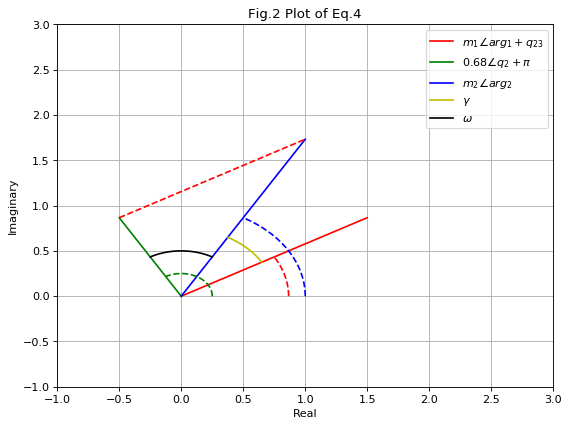

In [84]:
# prepare the complex number
def prepareComplexNumber(module,arg):
    _arr_m = np.linspace(0, module)
    _z_x = [_modul * np.cos(arg) for _modul in _arr_m]
    _z_y = [_modul * np.sin(arg) for _modul in _arr_m]
    return _z_x, _z_y

_z1_x, _z1_y = prepareComplexNumber(np.sqrt(3), np.pi/6)
_z2_x, _z2_y = prepareComplexNumber(1, 2*np.pi/3)
_z3_x, _z3_y = prepareComplexNumber(2, np.pi/3)

_tran_z1_x = np.array(_z1_x) + _z2_x[-1]
_tran_z1_y = np.array(_z1_y) + _z2_y[-1]

# prepare the angles
def prepareAngles(module, arg, scale_module, inf_arg=0):
    _arr_arg = np.linspace(inf_arg, arg)
    _z_arg_x = [scale_module * module * np.cos(ar) for ar in _arr_arg]
    _z_arg_y = [scale_module * module * np.sin(ar) for ar in _arr_arg]
    
    return _z_arg_x, _z_arg_y

_z1_arg_x, _z1_arg_y = prepareAngles(np.sqrt(3), np.pi/6, 0.5)
_z2_arg_x, _z2_arg_y = prepareAngles(1, 2*np.pi/3, 0.25)
_z3_arg_x, _z3_arg_y = prepareAngles(2, np.pi/3, 0.5)

gamma_x, gamma_y = prepareAngles(0.75, np.pi/3, 1, np.pi/6)
omega_x, omega_y = prepareAngles(0.5, 2*np.pi/3, 1, np.pi/3)


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Fig.2 Plot of Eq.4')
plt.plot(_z1_x, _z1_y, 'r-', label=r'$m_1 \angle arg_1+q_{23}$')
plt.plot(_z2_x, _z2_y, 'g-', label=r'$0.68 \angle q_2+\pi$')
plt.plot(_z3_x, _z3_y, 'b-', label=r'$m_2 \angle arg_2$')
plt.plot(_tran_z1_x, _tran_z1_y, 'r--')

plt.plot(_z1_arg_x, _z1_arg_y, 'r--')
plt.plot(_z2_arg_x, _z2_arg_y, 'g--')
plt.plot(_z3_arg_x, _z3_arg_y, 'b--')

plt.plot(gamma_x, gamma_y, 'y-', label=r'$\gamma$')
plt.plot(omega_x, omega_y, 'k-', label=r'$\omega$')

# plt.legend([r'$m_1 \angle arg_1+q_{23}$', r'$0.68 \angle q_2+\pi$', r'$m_2 \angle arg_2$' ])
plt.legend()
plt.grid()
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

$m_1 \angle arg_1$